In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import arviz as az
import pymc as pm
import warnings
from IPython.display import Image
import seaborn as sns
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

import tensorflow as tf
from tensorflow import keras

rng = np.random.RandomState(28)
tf.random.set_seed(28)

In [3]:
print(f'PyMC Version: {pm.__version__}')
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Arviz Version: {az.__version__}')
print(f'Sklearn Version: {sklearn.__version__}')

PyMC Version: 5.6.1
Numpy Version: 1.23.5
Pandas Version: 2.0.3
Arviz Version: 0.16.1
Sklearn Version: 1.3.0


In [4]:
df = pd.read_csv('apple2.csv', parse_dates=True, usecols=["Date", "Close", "return"])
df.head()

,Date,Close,return
0,2007-01-04,3.059286,0.021953
1,2007-01-05,3.037500,-0.007147
2,2007-01-08,3.052500,0.004926
3,2007-01-09,3.306071,0.079800
4,2007-01-10,3.464286,0.046746


## Plot daily change in returns:

On the y-axis are the logarithmic returns and the x-axis is again time in days since Jan. 4, 2007.

We see that, at some time points, the log returns are pretty stable (for example, from roughly 600-1000), while at other times, the log returns are very volatile (for example, from 300-500, the 2008 financial crisis, and at around 3250, the COVID-19 Pandemic).

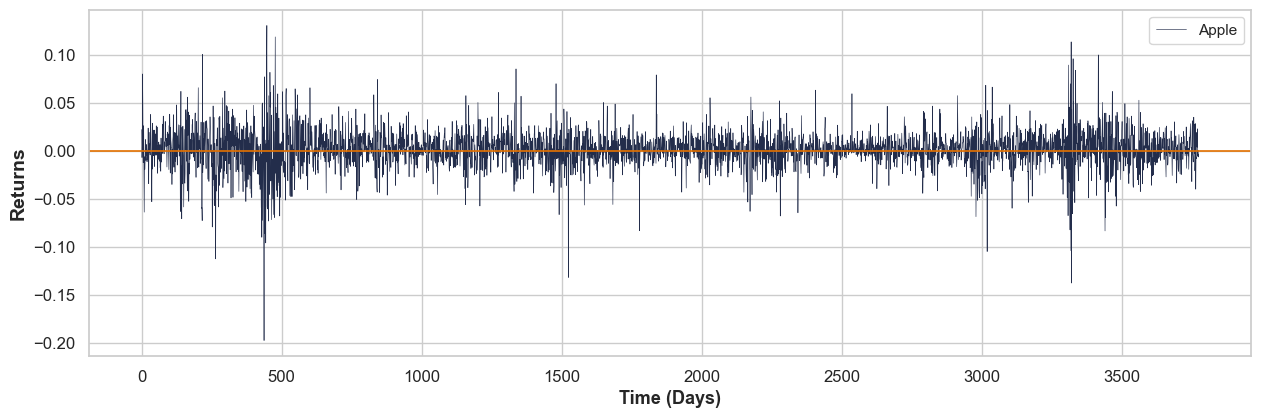

In [5]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(15, 4.5))
df.plot(y="return", label="Apple", ax=ax, color='#232D4B', linewidth=0.45)
ax.axhline(y=0, color='#E57200', linestyle='-', linewidth=1.2)
ax.set_xlabel("Time (Days)", fontsize=13, fontweight='bold') 
ax.set_ylabel("Returns", fontsize=14, fontweight='bold') 
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.savefig('apple_stock_returns_plot.png')

plt.show()

## Model Specification:

In [6]:
def sv_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        𝜎 = pm.Exponential("𝜎", 10)
        volatility = pm.GaussianRandomWalk(
            "volatility", sigma=𝜎, 
            dims="time", init_dist=pm.Normal.dist(0, 100)
        )
        𝜈 = pm.Exponential("𝜈", 0.1)
        returns = pm.StudentT(
            "returns", nu=𝜈, 
            lam=np.exp(-2 * volatility), 
            observed=data["return"], dims="time"
        )
    return model


svol_model = sv_model(df)

## Model Structure Graph:

$\nu \thicksim \text{exp}(0.1)$

$\sigma \thicksim \text{exp}(10)$

$s_i \thicksim N(s_{i-1}, \sigma^2)$

$\text{log}(r_i) \thicksim t(\nu, 0, \text{exp}(-2s_i)$

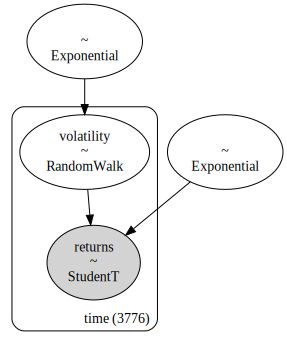

In [7]:
pm.model_to_graphviz(svol_model)

## Prior Predictive Samples:

In [36]:
with svol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = az.extract(idata, group="prior_predictive")

Sampling: [returns, volatility, 𝜈, 𝜎]


The chart below visualizes the returns and the simulated returns from the prior predictive samples to help us compare the observed data with the range of possible outcomes suggested by the prior predictive samples.

And the chart shows us some concerning things – mainly that prior predictive samples appear much larger than the observed returns, suggesting that the model is uncertain or overly flexible, which could be due to the choice of prior distributions, model structure, or parameter values. For now, we’ll ignore it and see what kind of results we get moving forward.

Note that chart only includes every 10th sample from the simulated returns to avoid overcrowding the plot.

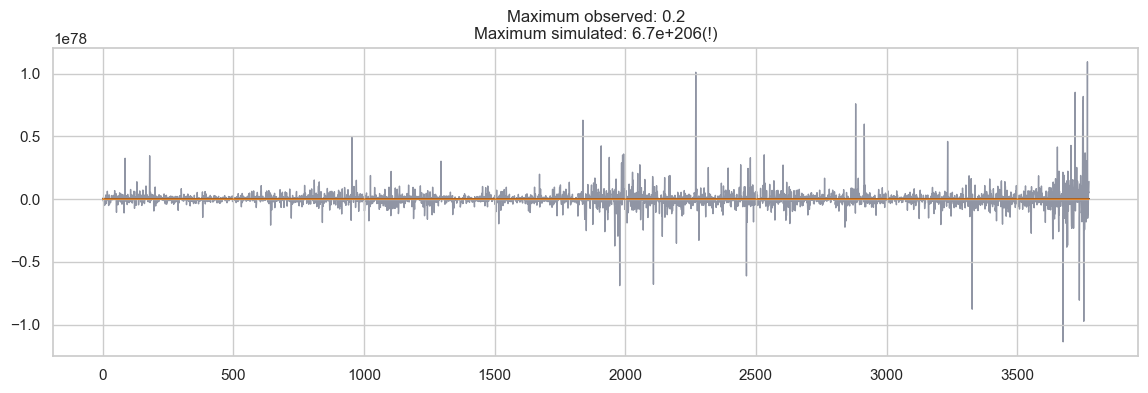

In [37]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(14, 4))
df["return"].plot(ax=ax, lw=1, color="#E57200")
ax.plot(
    prior_predictive["returns"][:, 0::10],
    "#232D4B",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(df["return"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

plt.savefig('apple_stock_returns2.png')
plt.show()

## Model Fitting:

In [35]:
with svol_model:
    idata.extend(pm.sample(10000, tune=500, init="adapt_diag", random_seed=rng))

posterior = idata.posterior.stack(pooled_chain=("chain", "draw"))
posterior["exp_volatility"] = np.exp(posterior["volatility"])

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, volatility, 𝜈]


Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 1356 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [36]:
with svol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = idata.posterior_predictive.stack(pooled_chain=("chain", "draw"))

Sampling: [returns]


Below are the trace plots of the distribution and sampled $𝜈$ and $𝜎$ posteriors.

The plots for the degrees of freedom parameter look decent; the chains are pretty consistent, indicating convergence.

But the step size parameter looks a bit rough. The chains aren't converging as we'd like. This may have to do with the $𝜎$ parameterization and how it impacts the random walk with standard deviation $𝜎$ and starting point $𝑠_0$; the scale of the innovations of the random walk is specified in terms of the standard deviation of the normally distributed innovations. In the case of a Gaussian random walk, these innovations are normally distributed random variables. This seems somewhat counterintuitive to, because we would think that the posterior of $𝑠_𝑖$ is not simply a scaled random walk as this would ignore the observed log return values. One thought is that we could allow the step size parameter to vary over time intervals, but I couldn’t figure out how to implement that in Python.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 120590 (\N{MATHEMATICAL ITALIC SMALL SIGMA}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 120584 (\N{MATHEMATICAL ITALIC SMALL NU}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120590 (\N{MATHEMATICAL ITALIC SMALL SIGMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120584 (\N{MATHEMATICAL ITALIC SMALL NU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


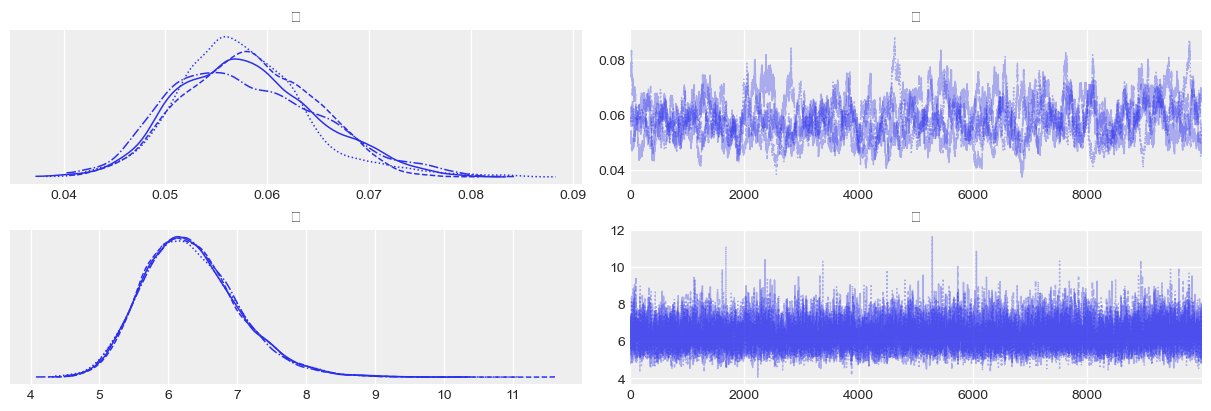

In [37]:
az.style.use("arviz-darkgrid")
az.plot_trace(idata, var_names=["𝜎", "𝜈"]);

array([<Axes: title={'center': '𝜎'}>, <Axes: title={'center': '𝜈'}>],
      dtype=object)

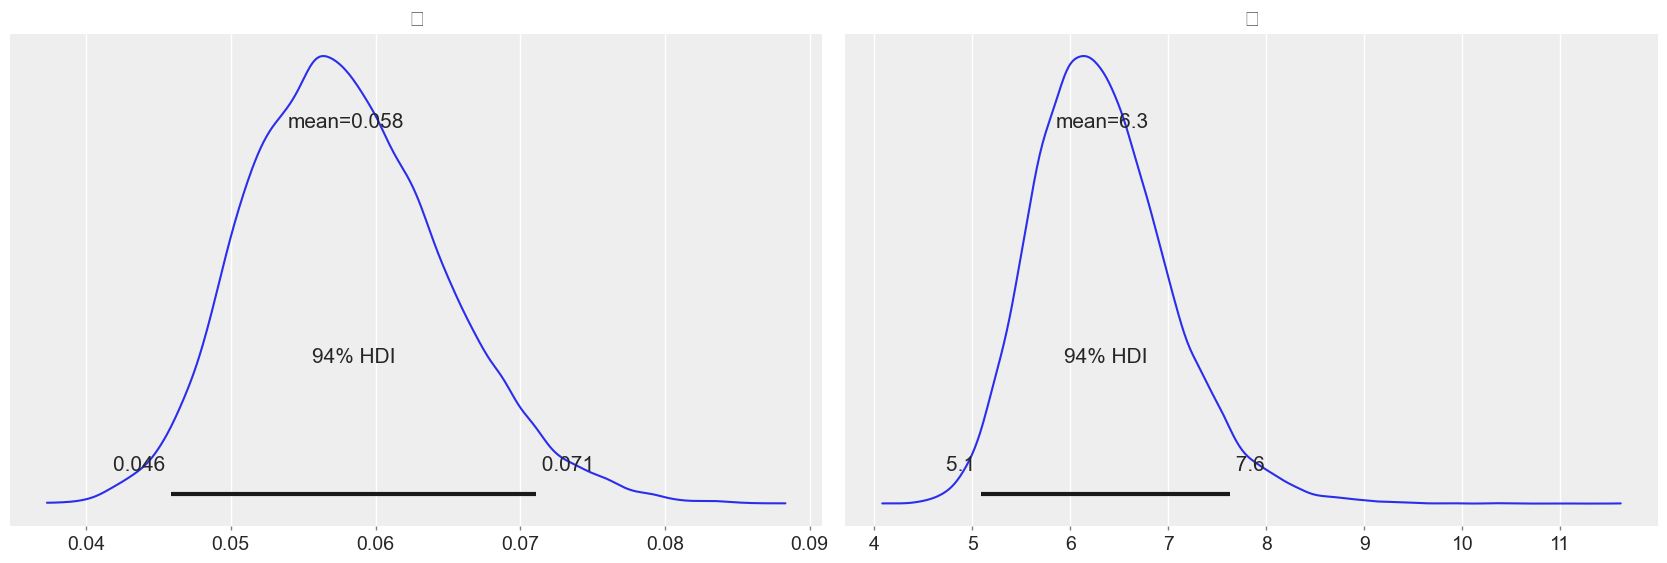

In [47]:
az.plot_posterior(idata, var_names=["𝜎", "𝜈"], kind='kde')

The next two plots below compare the observed data's kernel density estimate (KDE) with the KDEs of the data generated by the model's posterior predictive samples. This helps us visually assess how well the model captures the distribution of the observed data.

These plots provides insights into how well the stochastic volatility model fits the observed Apple stock returns. The plots suggest that the model captures the underlying patterns in the data.

<Axes: xlabel='returns / returns'>

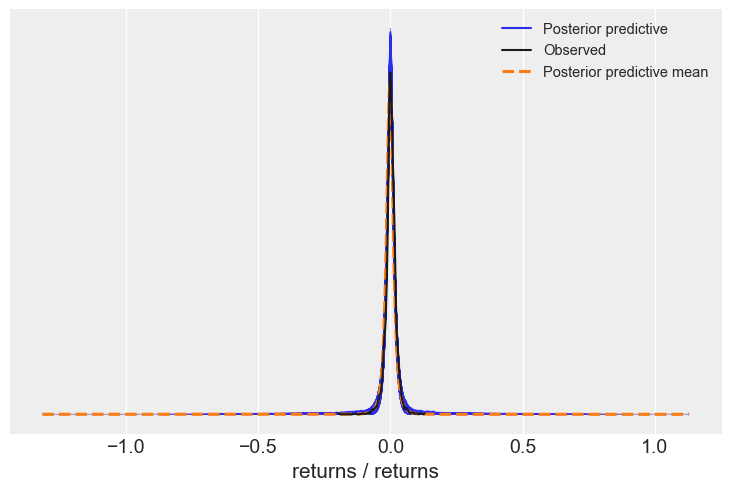

In [39]:
az.plot_ppc(idata, data_pairs={"returns":"returns"}, alpha=0.5)

<Axes: xlabel='returns / returns'>

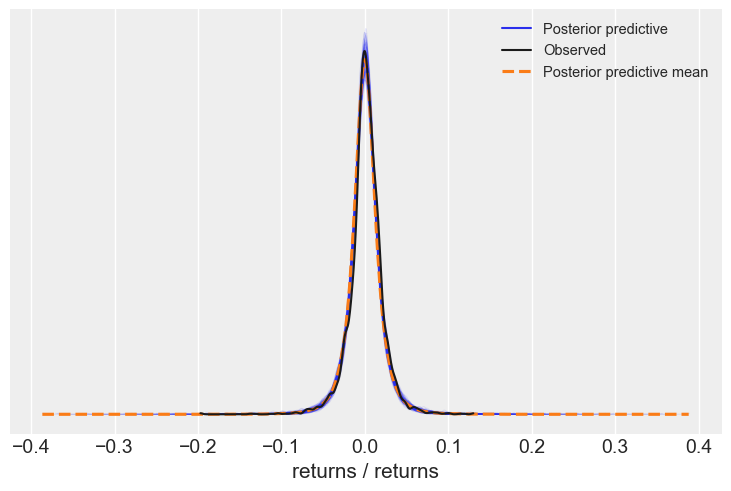

In [46]:
az.plot_ppc(idata, num_pp_samples=100, random_seed=28, alpha=0.1)

## Posterior Estimates of Volatility in Apple returns over time:

This chart shows the posterior estimates of the volatility in Apple returns over time.

Clearly there are time periods with high volatility (the financial crisis, around 2400-2500, and the COVID-19 pandemic, around 5300-5500). These peaks in volatility also have higher uncertainty around them (measured by the vertical width of the graph), which is somewhat intuitive; that is, higher volatility usually means unpredictable markets, making the volatility difficult to estimate.

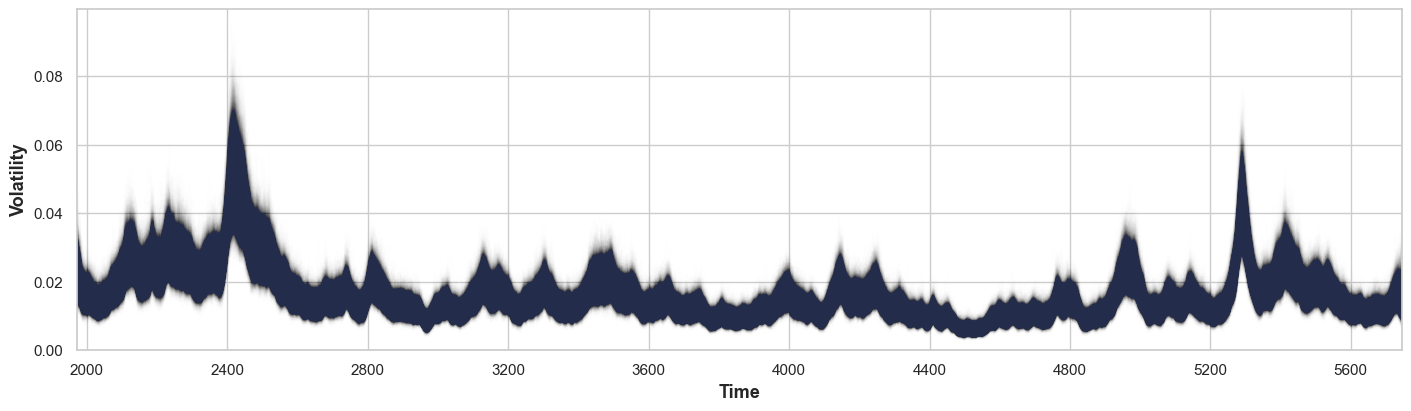

In [73]:
sns.set(style='whitegrid')
y_vals = posterior["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
time_values = y_vals.time.values
x_vals = np.array(time_values, dtype='datetime64[Y]')
fig, ax = plt.subplots(figsize=(14, 4))
plt.plot(x_vals, y_vals, alpha=0.002, color="#232D4B")
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set_xlabel("Time", fontsize=13, fontweight='bold') 
ax.set_ylabel("Volatility", fontsize=13, fontweight='bold')

plt.savefig('apple_stock_returns3.png')
plt.show()

## How the learned volatility impacts returns:

This chart shows the posterior predictive distribution and can help us discern how the learned volatility could have impacted returns.

We’re seeing the observed log returns, the posterior mean of the exponential of the latent volatility, and the posterior predictive samples of log returns. 

The orange line represents the true log returns of the Apple stock time series. This is the actual observed behavior of returns in the market.

The blue line in the top subplot represents the posterior predictive log returns – that is, the simulated log returns generated by the model based on the learned parameters, including the posterior distribution of volatility. The transparency of the line allows us to see where the model's predictions align or diverge from the true log returns.

Similar to the previous slide, in the second row of the subplot, the width at a particular time represents the uncertainty in the estimated volatility at that time.

So, we see the model does pretty well at explaining the greater uncertainty during the financial crisis and COVID-19 pandemic.

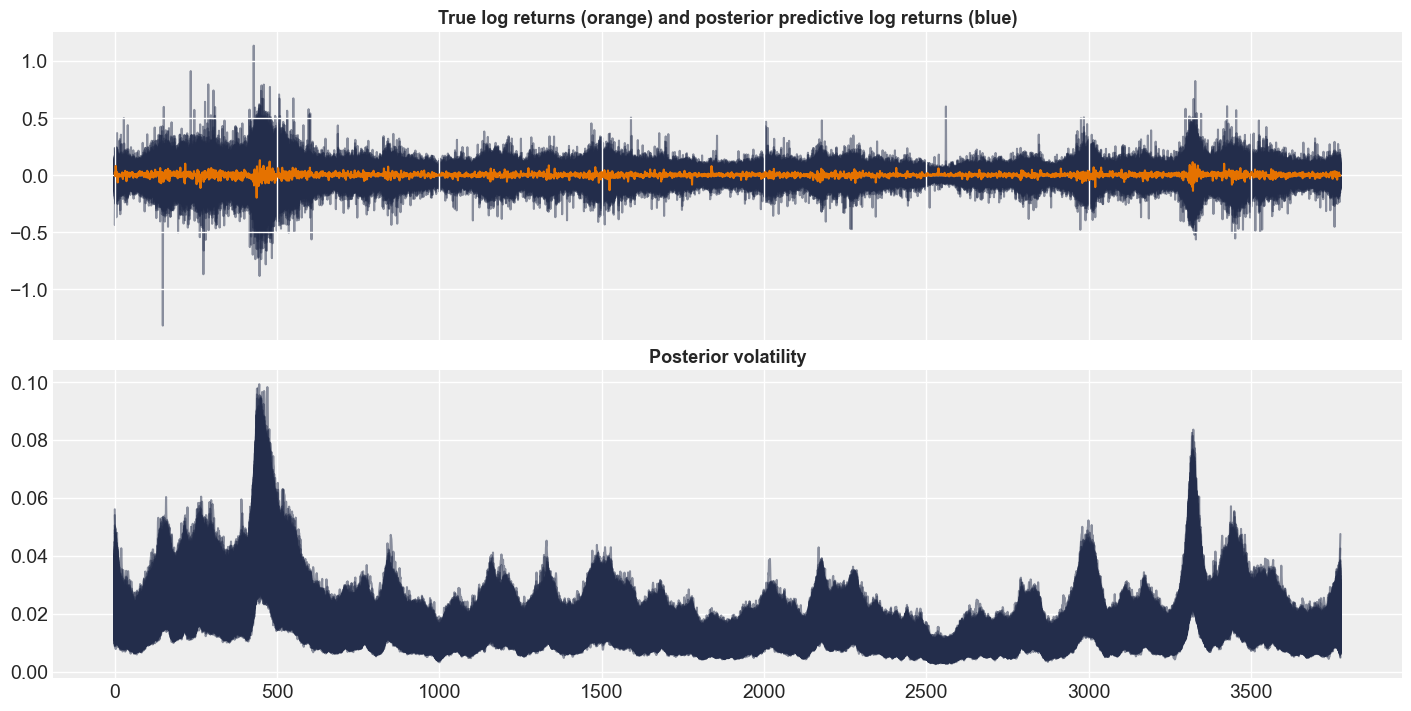

In [49]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
df["return"].plot(ax=axes[0], color="#E57200")

axes[1].plot(posterior["exp_volatility"], "#232D4B", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"],
    color="#232D4B",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (orange) and posterior predictive log returns (blue)", fontsize=13, fontweight='bold')
axes[1].set_title("Posterior volatility", fontsize=13, fontweight='bold');
plt.savefig('apple_stock_returns4.png')